# Do wealthier people share a roof with more or less people? A study of household size and income in the city of Barcelona

## 1. Importing libraries
We'll start by importing the libraries we'll need.

In [8]:
import numpy as np
import pandas as pd
import json
import geopandas as gpd
import plotly.graph_objects as go

from statsmodels.nonparametric.smoothers_lowess import lowess #this last function will help us visualize overall trends

<class 'ModuleNotFoundError'>: No module named 'plotly'

## 2. Customizing visualization parameters
Next we'll tweak a few things to display the data better, as well as to change a bit the default plotting theme to make it more visually pleasing.

In [2]:
#Set maximum rows and columns when displaying data
pd.set_option('display.max_columns', None) #no maximum number of columns
pd.set_option('display.max_rows', 25) #maximum number of rows

# Create the layout for figures with a custom theme
mylayout = go.Layout(
        xaxis=dict(linecolor='black', gridcolor='lightgrey'), #x-axis line and grid color
        yaxis=dict(linecolor='black', gridcolor='lightgrey'), #same for y-axis
        paper_bgcolor='white',  #background color
        plot_bgcolor='white')  #plot area background color

#defining a color palette for our figures, as well as a matching lighter palette for some plot details
palcolors = ['#04BB85','#8F76D7','#FF9500','#019BBF','#F62F36','#9D5E31','#E65898','#B1C019','#FDC903','#C1A471'] 
palcolors_light = ['#7ADFA7', '#D5C2FF', '#FFE07F', '#49B3FF', '#FF8B8F', '#E9BEA8', '#FFA4D3', '#E5F075', '#FFE947', '#F4DDAD']

<class 'NameError'>: name 'go' is not defined

## 3. First dataset: yearly net income per person 
We'll first focus on the dataset containing the information on the average tax revenue per person, or what's the same, the yearly average net income per person. The data comes from the city of Barcelona, and it can be accessed in [its City Council's website](https://opendata-ajuntament.barcelona.cat/data/en/dataset/renda-tributaria-per-persona-atlas-distribucio/resource/7e2ab9ed-68ea-43ea-abb0-afbb620ee09e).

After loading the data as DataFrame, we'll have to adapt some headers and values, and then we'll visualize it.



### 3.1. Loading the yearly income per person dataset

After loading the dataset we can display it. As you can see, the header for each column is not in English, but in Catalan. We'll take care of that next. 

In [3]:
#load as DataFrame
df_indivincome = pd.read_csv('2021_renda_neta_mitjana_per_persona.csv')

#display the DataFrame
display(df_indivincome)

<class 'FileNotFoundError'>: [Errno 44] No such file or directory: '2021_renda_neta_mitjana_per_persona.csv'

### 3.2. Data preparation
Let's get our data frame up and running. To start, we'll eliminate the `Any` column, which simply indicates the year the data refers to, and then rename all other variables to English.

In [4]:
#trim and rename original columns
df_indivincome = df_indivincome.drop(['Any'], axis=1) #delete 'Any' column, which does not provide any useful information

df_indivincome = df_indivincome.set_axis(['district_code', 'district_name', 'neighborhood_code', 'neighborhood_name','census_section','income_per_person'], axis=1) #renaming all column names to English

#display the DataFrame
display(df_indivincome)

<class 'NameError'>: name 'df_indivincome' is not defined

We can see that our data contains six columns:
- `district_code`: a 1-to-10 digit value for each of the 10 districts of Barcelona.
- `district_name`: the name of the district itself.
- `neighborhood_code`: a 1-to-71 value for each of the 71 neighborhoods of Barcelona, each forming part of a specitif district.
- `neighborhood_name`: the name of the neighborhood itself.
- `census_section`: a 1-to-n value representing each of the census sections, the smallest subdivisions of the city, with each district having a different number of them. Note that, unlike neighborhood_code, this variable is not unique for a given census section within the city, as all districts start their census sections from section 1.
- `income_per_person`: a numeric value representing the average net income a person has for that particular district, neighborhood and census section.

We just mentioned that the `census_section` column does not possess unique identifiers for each census section of the city. Oddly enough, other Barcelona datasets, like the one we'll load later, employ another coding system, which is actually better for our purposes. In this other system, each census area is uniquely represented by a number consisting of the district code plus the census area code, the latter always expressed as 3 digits. Thus, census section 1 of district 2 will appear as 2001, and census section 34 of district 10 will be 10034. In order to have unique identifiers for each census section in our current data set, and also to be able to merge our datasets early on, we'll replace the values in `census_section` to adopt the better codification. We'll do that by defining a function and then passing the function to our DataFrame.

In [5]:
#create an extra column providing a unique identifier for each census section of the city.
def create_census_section_column(row):
    return str(row['district_code']) + str(row['census_section']).zfill(3) #this is created by appending a 3-digit census section to the district code

df_indivincome['census_section'] = df_indivincome.apply(create_census_section_column, axis=1)

#display the DataFrame
display(df_indivincome)

<class 'NameError'>: name 'df_indivincome' is not defined

### 3.3. Visualizing income across districts
Even if our objective is to relate income and household size, it's a good practice to start by visualizing each variable on its own. We'll first visualize, then, how income is distributed across our census sections. Since there are 1068 census areas in the city, we'll group them by district. With such abundant data points, it's helpful to also represent the general trend as a density. One of the most intuitive ways of doing so are violin plots.

Below is the code to create the visualization with the help of the plotly library. Instead of the more sparse plotly express, I like to use plotly's graphical objects, which offer greater customization, even if at the expense of more lines of code. In this case, since I want the color of the data to depend on the district, I will have to define a for loop to assign the color and then append the violin to a list.

In [6]:
#create the list of violin objects with different colors

violins = [] #create an empty list

district_names = ['Ciutat Vella', "L'Eixample", 'Sants-Montjuïc', 'Les Corts', 'Sarrià-Sant Gervasi', 'Gràcia', 'Horta-Guinardó', 'Nou Barris', 'Sant Andreu', 'Sant Martí'] #list with each district's name, in the order we want it

for i, district_name in enumerate(district_names): #loop over all districts
    district_data = df_indivincome.loc[df_indivincome['district_name'] == district_name, 'income_per_person']

    violin = go.Violin( #defining parameters for the plot
        y=district_data,
        box_visible=False,
        line_color=palcolors[i],
        fillcolor=palcolors_light[i],
        points='all',
        pointpos=0,
        jitter=1,
        marker=dict(color=palcolors[i], size=8, line=dict(color=palcolors_light[i], width=1)),
        hoveron='points',
        name=district_name,
        showlegend=False,
        customdata=np.column_stack(( #choosing the columns to display information when hovering with the mouse on the data points
            df_indivincome.loc[df_indivincome['district_name'] == district_name, 'district_name'],
            df_indivincome.loc[df_indivincome['district_name'] == district_name, 'neighborhood_name'],
            df_indivincome.loc[df_indivincome['district_name'] == district_name, 'census_section'],
            district_data
        )),
        hovertemplate=( #assigning a template to structure and label the aforementioned information
            '<br><b>District: %{customdata[0]}</b></br>'
            '<b>Neighborhood: %{customdata[1]}</b>'
            '<br><b>Census section: %{customdata[2]}</b></br>'
            '<b>Income: %{customdata[3]}</b><extra></extra>'
        )
    )
    violins.append(violin) #append current violin to the list

#create the figure
fig1 = go.Figure(data=violins, layout=mylayout)

#update my custom layout with some elements specific to this figure
fig1.update_layout(
    xaxis=dict(title='District'),
    yaxis=dict(title='Income per person/year (1000s €)'),
    margin=dict(l=100, r=25, b=50, t=25),#customizing margins
    showlegend=False #no legends
)

#show the figure
fig1.show()

<class 'NameError'>: name 'df_indivincome' is not defined

Quite a lot of data! Overall, the violins, which are just mirrored densities, help appreciate the concentration of data along the y-axis, which expresses the income per person/year in 1000s of euros.

We can clearly see that some districts are on the wealthy side, like Sarrià-Sant Gervasi and Les Corts. Others are much more modest, like Ciutat Vella and Nou Barris. And some are quite homogeneous (Gràcia), while others are very diverse (Sant Martí).

## 3. Second dataset: number of tenants per household
Next up we'll move on to our second dataset, containing the average number of people living in a household, split by city subdivisions. The dataset can also be found on [the City Council's website](https://opendata-ajuntament.barcelona.cat/data/en/dataset/pad_dom_mdbas_n-persones/resource/66985e32-b3c1-4f3e-a987-f880a4c509d3).

We'll follow the same procedure: data loading, processing and visualization.

### 3.1. Loading the dataset

In [77]:
#load as DataFrame
df_numtenants = pd.read_csv('2021_pad_dom_mdbas_n-persones.csv')

#display the DataFrame
display(df_numtenants)

,Data_Referencia,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,AEB,Seccio_Censal,Valor,N_PERSONES_AGG
0,2021-01-01,1,Ciutat Vella,1,el Raval,1,1001,201,1
1,2021-01-01,1,Ciutat Vella,1,el Raval,1,1001,127,2
2,2021-01-01,1,Ciutat Vella,1,el Raval,1,1001,66,3
3,2021-01-01,1,Ciutat Vella,1,el Raval,1,1001,56,4
4,2021-01-01,1,Ciutat Vella,1,el Raval,1,1001,23,5
...,...,...,...,...,...,...,...,...,...
9265,2021-01-01,10,Sant Martí,73,la Verneda i la Pau,233,10143,39,5
9266,2021-01-01,10,Sant Martí,73,la Verneda i la Pau,233,10143,17,6
9267,2021-01-01,10,Sant Martí,73,la Verneda i la Pau,233,10143,10,7
9268,2021-01-01,10,Sant Martí,73,la Verneda i la Pau,233,10143,7,8


### 3.2. Data preparation
As before, we'll keep only the useful columns and those will be renamed to English.

In [78]:
df_numtenants = df_numtenants.filter(items=['Nom_Districte','Nom_Barri','Seccio_Censal','Valor','N_PERSONES_AGG']) #select only useful columns

df_numtenants = df_numtenants.set_axis(['district_name', 'neighborhood_name','census_section','n_households','n_people'], axis=1) #renaming all column names to English

df_numtenants['district_name'] = df_numtenants['district_name'].replace(to_replace="Eixample", value="L'Eixample")

#display the DataFrame
display(df_numtenants)

,district_name,neighborhood_name,census_section,n_households,n_people
0,Ciutat Vella,el Raval,1001,201,1
1,Ciutat Vella,el Raval,1001,127,2
2,Ciutat Vella,el Raval,1001,66,3
3,Ciutat Vella,el Raval,1001,56,4
4,Ciutat Vella,el Raval,1001,23,5
...,...,...,...,...,...
9265,Sant Martí,la Verneda i la Pau,10143,39,5
9266,Sant Martí,la Verneda i la Pau,10143,17,6
9267,Sant Martí,la Verneda i la Pau,10143,10,7
9268,Sant Martí,la Verneda i la Pau,10143,7,8


So in this data we have our old friends `district_name`, `neighborhood_name` and `census_section`. Notice that this last variable is already in the format we had to wrangle our former dataset to. The two other columns are new:
- `n_people`: an integer describing a certain amount of people (1, 2, 3, ...)
- `n_households`: number of households having the exact amount of people specified in `n_people`

What this format means is that, for census section 1001, I have 127 households with 2 tenants in each of them, and 23 households with 5 people in each. This data frame is not ripe for us to use yet. What we need is a single row for each census section with a column specifying the average people per household for that city subdivision. We'll do that next.

In [79]:
df_numtenants['weighted_n_people'] =  df_numtenants['n_people'] * df_numtenants['n_households'] #multiply n_people and n_households to get a weighted number of people

df_numtenants = (df_numtenants
.groupby(['district_name', 'neighborhood_name','census_section'])[['weighted_n_people', 'n_households']]
.sum()
.reset_index()) #alculating summatory of n_households

df_numtenants['mean_people_household'] = round(df_numtenants['weighted_n_people'] / df_numtenants['n_households'], 2) #use our new varialbes to finally obtain average number of tenants per household, rounded to 2 decimals

df_numtenants = df_numtenants.drop('weighted_n_people', axis=1) #delete weighted_n_people columns, as we do not need it anymore

### 3.3. Visualizing the average number of tenants per households across districts

We'll apply the same procedure we followed on section 3.3., only this time visualizing the average number of tenants per household, the variable we just calculated in our current data frame.

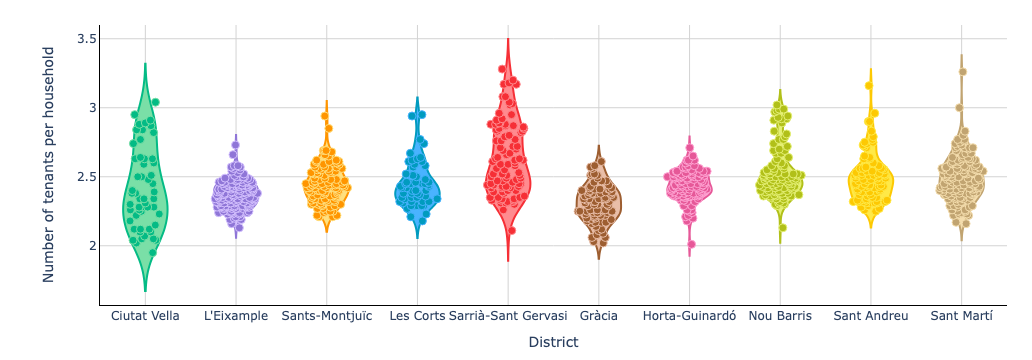

In [80]:

#create the list of violin objects with different colors

violins = [] #create an empty list

for i, district_name in enumerate(district_names): #loop over all districts
    district_data = df_numtenants.loc[df_numtenants['district_name'] == district_name, 'mean_people_household']

    violin = go.Violin( #defining parameters for the plot
        y=district_data,
        box_visible=False,
        line_color=palcolors[i],
        fillcolor=palcolors_light[i],
        points='all',
        pointpos=0,
        jitter=1,
        marker=dict(color=palcolors[i], size=8, line=dict(color=palcolors_light[i], width=1)),
        hoveron='points',
        name=district_name,
        showlegend=False,
        customdata=np.column_stack(( #choosing the columns to display information when hovering with the mouse on the data points
            df_numtenants.loc[df_numtenants['district_name'] == district_name, 'district_name'],
            df_numtenants.loc[df_numtenants['district_name'] == district_name, 'neighborhood_name'],
            df_numtenants.loc[df_numtenants['district_name'] == district_name, 'census_section'],
            district_data
        )),
        hovertemplate=( #assigning a template to structure and label the aforementioned information
            '<br><b>District: %{customdata[0]}</b></br>'
            '<b>Neighborhood: %{customdata[1]}</b>'
            '<br><b>Census section: %{customdata[2]}</b></br>'
            '<b>People per household: %{customdata[3]}</b><extra></extra>'
        )
    )
    violins.append(violin) #append current violin to the list

#create the figure
fig2 = go.Figure(data=violins, layout=mylayout)

#update my custom layout with some elements specific to this figure
fig2.update_layout(
    xaxis=dict(title='District'),
    yaxis=dict(title='Number of tenants per household'),
    margin=dict(l=100, r=25, b=50, t=25),#customizing margins
    showlegend=False #no legends
)

#show the figure
fig2.show()

What do we see here? Well, some sections of wealthy districts, like Sarrià-Sant Gervasi, seem to have more people living in the same household. But we also see quite a lot of disparity for districts like Ciutat Vella.

## 5. Final, combined dataset
The best way to discover how our two variables of interest intersect is to visualize them together, so let's get down to it. We'll need to merge both datasets and then choose an appropriate plot type.

### 5.1. Merging both datasets
In order to combine the income and the tenants data frames, we'll use `merge`, taking the former dataset as a reference. We'll simplify the latter in order to have only one common column, `census_section`, by which to merge both.

In [81]:
#create a only variable of interest and a unique identifier that is common with the other dataframe
df_numtenants_short = df_numtenants.filter(items=['census_section', 'mean_people_household'])
df_numtenants_short['census_section'] = df_numtenants_short['census_section'].astype(str) #convert census_section to string it matches type of the same variable for the other DataFrame

final_df = pd.merge(df_indivincome,df_numtenants_short, how='left', on= ['census_section'])

#display the DataFrame
display(final_df)

,district_code,district_name,neighborhood_code,neighborhood_name,census_section,income_per_person,mean_people_household
0,1,Ciutat Vella,1,el Raval,1001,11166,2.50
1,1,Ciutat Vella,1,el Raval,1002,9115,2.63
2,1,Ciutat Vella,1,el Raval,1003,9431,2.91
3,1,Ciutat Vella,1,el Raval,1004,10898,2.63
4,1,Ciutat Vella,1,el Raval,1005,9717,2.51
...,...,...,...,...,...,...,...
1063,10,Sant Martí,73,la Verneda i la Pau,10143,12705,2.64
1064,10,Sant Martí,65,el Clot,10234,16081,2.50
1065,10,Sant Martí,69,Diagonal Mar i el Front Marítim del Poblenou,10235,14455,2.16
1066,10,Sant Martí,69,Diagonal Mar i el Front Marítim del Poblenou,10236,14844,2.28


### 5.2. Visualizing data
Showtime! To see how income and household size are related, we'll just plot one variable against the other. We'll stick to a simple scatterplot, but we'll color each datapoint, representing a census section, according to the district it belongs to. This will help us identify whether the data clusters as a function of that variable. We'll also add a LOWESS (locally weighted scatterplot smoothing) line, which is a model-agnostic way to visualize the trend of the data better.

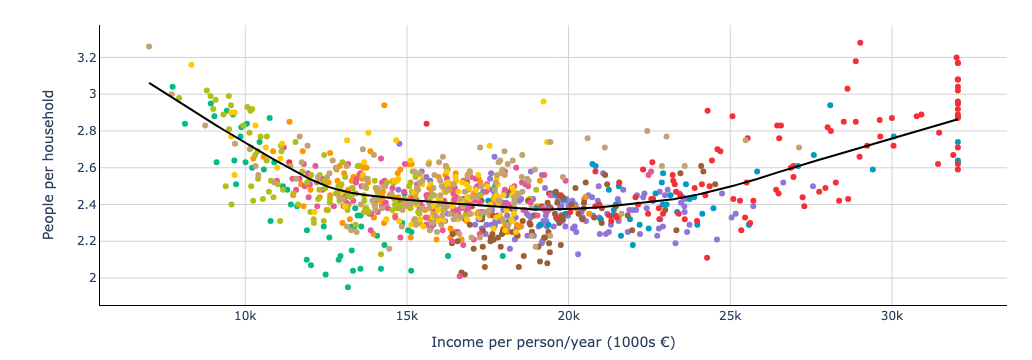

In [82]:
# map the colors to each row in the DataFrame
district_colors = dict(zip(final_df["district_code"].unique(), palcolors)) #dictionary matching district code and corresponding color
final_df['color'] = final_df['district_code'].map(district_colors)

#create the scatterplot
scatter = go.Scatter(
    x=final_df["income_per_person"],
    y=final_df["mean_people_household"],
    mode='markers',
    marker=dict(color=final_df['color']),
    text=final_df['neighborhood_name'],
    customdata= np.stack((final_df['district_name'], final_df['neighborhood_name'], final_df['census_section'], final_df['income_per_person'], final_df['mean_people_household']), axis=-1),
    hovertemplate =
    '<br><b>District: %{customdata[0]}</b></br>' + 
    '<b>Neighborhood: %{customdata[1]}</b>' + 
    '<br><b>Census section: %{customdata[2]}</b></br>' + 
    '<b>Income per person/year: %{customdata[3]}</b>' + 
    '<br><b>People per household: %{customdata[4]}</b><extra></extra></br>' #add extra to remove trace:0 right next to hover box
)

#calculate LOWESS line
final_df = final_df.sort_values(by='income_per_person') #sort the DataFrame by the 'income_per_person' column, necessary to calculate the LOWESS line
lowess_result = lowess(final_df["mean_people_household"], final_df["income_per_person"], frac=0.3)
lowess_line = go.Scatter(
    x=final_df["income_per_person"],
    y=lowess_result[:, 1],
    mode='lines',
    line=dict(color='black', width=2),
    hoverinfo='none',
)

#create Figure
fig3 = go.Figure(data=[scatter, lowess_line], layout=mylayout)

#update layout with axes titles and margins
fig3.update_layout(
    xaxis=dict(title='Income per person/year (1000s €)'),
    yaxis=dict(title='People per household'),
    margin=dict(l=100, r=25, b=50, t=25),#customizing margins
    showlegend=False
)

#show the figure
fig3.show()

And there we have it, it's a clear U-shape relationship. People in low-income areas tend to live in households with more people, but as we move into mid-income city areas the number of tenants declines. However, high-income neighbrhoods are again characterized by households with more people. Colors show that some districts form clusters at different points along the spectrum.

## 6. Bonus track: introducing apartment size
So should the take-home message be that richer people live in crammed apartments? Not necessarily... We have not factored in the size of those apartments yet. It would be logical to suppose that the more financially privileged would live in more spacious places. Let's test this hypothesis out then.

In order to conduct this final part of the project we'll need two more datasets.

The first dataset, available on the [website of the Catalan government](https://habitatge.gencat.cat/ca/dades/indicadors_estadistiques/estadistiques_de_construccio_i_mercat_immobiliari/mercat_de_lloguer/lloguers-barcelona-per-districtes-i-barris/), contains the average rental apartment size across neighborhoods in the city of Barcelona. You may have already caught two problems here... First, the dataset only includes rental apartments, so our data will not contain the apartments people own. The second problem is that the data is offered per neighborhood, without offering the more fine-grained census section information. This second issue forces us to have to take the dataset we've used before, and calculate income and household size for each neighborhood. To do it, one could quickly average across census sections, but those sections have a different population. Thus, we have to retrieve the population for each census section from yet another [dataset from the Barcelona city council](https://opendata-ajuntament.barcelona.cat/data/en/dataset/pad_mdbas_sexe/resource/86ab6583-6c83-412c-bdce-8b52077a821a), and use this information to calculate our variables appropriately.

### 6.1. Loading the apartment mean size dataset

This dataset is not offered as a clean .csv file, but as a dirty Excel file with multiple headers and inconsistent formatting. So after inspecting the file, we can choose which rows and columns to include, and rename the variables.

In [83]:
#load as DataFrame
df_sizeapts = pd.read_excel(
    'anual_bcn_sup.xlsx',
    header=None, #skip the headers, we'll introduce them below in English
    usecols=[0, 3], #use only 1st and 4th column, corresponding to neighborhood code and to apartment size for the year 2021 
    skiprows= list(range(0, 19)) + list(range(92, pd.read_excel('anual_bcn_sup.xlsx', header=None).shape[0])) #take the rows corresponding to the actual data for each neighborhood
)

# Rename the columns and round the variable of interest
df_sizeapts.columns = ['neighborhood_code', 'mean_size']

df_sizeapts['mean_size'] = round(df_sizeapts['mean_size'],2)

display(df_sizeapts)


,neighborhood_code,mean_size
0,1,63.47
1,2,83.42
2,3,56.30
3,4,71.89
4,5,75.64
...,...,...
68,69,84.81
69,70,64.15
70,71,72.22
71,72,72.15


### 6.2. Loading the population per census section dataset
As said above, since the apartment size dataset only includes information per neighborhood, we need to calculate income and household size per neighborhood too. But for that we'll need information about the population for each census section, provided in another dataset. After loading it, we'll have to wrangle it too, as information is provided separately for women and men. Let's do all this quickly, without stopping to see the result of the intermediate steps.

In [84]:
#load as DataFrame
df_popcensec = pd.read_csv('2021_pad_mdbas_sexe.csv')

df_popcensec = df_popcensec.filter(items=['Seccio_Censal','Valor','SEXE']) #select only useful columns

df_popcensec = df_popcensec.set_axis(['census_section','population','sex'], axis=1) #renaming all column names to English

#pivot the dataframe to wider format, where women and men have separate columns
df_popcensec = df_popcensec.pivot(index='census_section', columns='sex', values='population').reset_index()

#rename columns
df_popcensec.columns = ['census_section', 'population_women', 'population_men']

#sum the population for men and women
df_popcensec['population'] = df_popcensec['population_women'] + df_popcensec['population_men']

#delete the separate women and men columns, as we do not need them anymore
df_popcensec = df_popcensec.drop(['population_women','population_men'], axis=1)

#display the DataFrame
display(df_popcensec)

,census_section,population
0,1001,1311
1,1002,1489
2,1003,3661
3,1004,2972
4,1005,2448
...,...,...
1063,10143,1727
1064,10234,1829
1065,10235,1329
1066,10236,1617


The next step is recovering our "final" dataframe from section 5, adding the population information to it and calculating the variables `income_per_person` and `mean_people_household` collapsing across census sections within neighborhood, taking into account the population of each census section.

In [85]:
#make a copy of final_df to start working towards the neighborhood data frame
df_hoods = final_df.copy()

#merge the recently copied data frame with the population per census district data frame
df_popcensec['census_section'] = df_popcensec['census_section'].astype(str) #turning common merging variable into string

df_hoods = pd.merge(df_hoods,df_popcensec, how='left', on= ['census_section']) #merging

#define the grouping variables before applying the data transformations
df_hoods = df_hoods.groupby(['district_code', 'district_name', 'color', 'neighborhood_code', 'neighborhood_name'])

#define a general weighted mean function that we'll use for each of the two variables we want to summarize 
def weighted_mean(group, column, weight_column):
    return (group[column] * group[weight_column]).sum() / group[weight_column].sum()

#apply the general weighted mean function
df_hoods = df_hoods.apply(lambda group: pd.Series({
    'population': group['population'].sum(),
    'income_per_person': round( weighted_mean(group, 'income_per_person', 'population'), 2),
    'mean_people_household': round( weighted_mean(group, 'mean_people_household', 'population'), 2)
}), include_groups=False).reset_index()

#display the DataFrame
display(df_hoods)


,district_code,district_name,color,neighborhood_code,neighborhood_name,population,income_per_person,mean_people_household
0,1,Ciutat Vella,#04BB85,1,el Raval,48688.0,10053.37,2.73
1,1,Ciutat Vella,#04BB85,2,el Barri Gòtic,22850.0,13697.22,2.32
2,1,Ciutat Vella,#04BB85,3,la Barceloneta,15125.0,13238.96,2.17
3,1,Ciutat Vella,#04BB85,4,"Sant Pere, Santa Caterina i la Ribera",23009.0,14227.04,2.23
4,2,L'Eixample,#8F76D7,5,el Fort Pienc,33445.0,18137.79,2.45
...,...,...,...,...,...,...,...,...
68,10,Sant Martí,#C1A471,69,Diagonal Mar i el Front Marítim del Poblenou,13536.0,19237.37,2.52
69,10,Sant Martí,#C1A471,70,el Besòs i el Maresme,26116.0,10938.22,2.73
70,10,Sant Martí,#C1A471,71,Provençals del Poblenou,21185.0,15626.82,2.54
71,10,Sant Martí,#C1A471,72,Sant Martí de Provençals,26229.0,14919.70,2.46


### 6.3. Merging both datasets and visualizing the result
Almost there! Let's merge the two data frames we've produced on section 6.

In [86]:
df_hoods = pd.merge(df_hoods,df_sizeapts, how='left', on= ['neighborhood_code'])

#display the DataFrame
display(df_hoods)

,district_code,district_name,color,neighborhood_code,neighborhood_name,population,income_per_person,mean_people_household,mean_size
0,1,Ciutat Vella,#04BB85,1,el Raval,48688.0,10053.37,2.73,63.47
1,1,Ciutat Vella,#04BB85,2,el Barri Gòtic,22850.0,13697.22,2.32,83.42
2,1,Ciutat Vella,#04BB85,3,la Barceloneta,15125.0,13238.96,2.17,56.30
3,1,Ciutat Vella,#04BB85,4,"Sant Pere, Santa Caterina i la Ribera",23009.0,14227.04,2.23,71.89
4,2,L'Eixample,#8F76D7,5,el Fort Pienc,33445.0,18137.79,2.45,75.64
...,...,...,...,...,...,...,...,...,...
68,10,Sant Martí,#C1A471,69,Diagonal Mar i el Front Marítim del Poblenou,13536.0,19237.37,2.52,84.81
69,10,Sant Martí,#C1A471,70,el Besòs i el Maresme,26116.0,10938.22,2.73,64.15
70,10,Sant Martí,#C1A471,71,Provençals del Poblenou,21185.0,15626.82,2.54,72.22
71,10,Sant Martí,#C1A471,72,Sant Martí de Provençals,26229.0,14919.70,2.46,72.15


And let's finally visualize the data. The challenge here is representing three variables: income, number of tenants per household, and apartment size. In order to keep it as similar as possible to our former plot, let's leave the x- and y-axes the same. The newly introduced variable, apartment size, will be displayed as the size of the dots (which now will represent neighborhoods). The only technical tweak here is to normalize the size of the dots according to the maximum size we want to display. We do this to maximize visual differences, that would be minimal if passing the absolute apartment sizes.

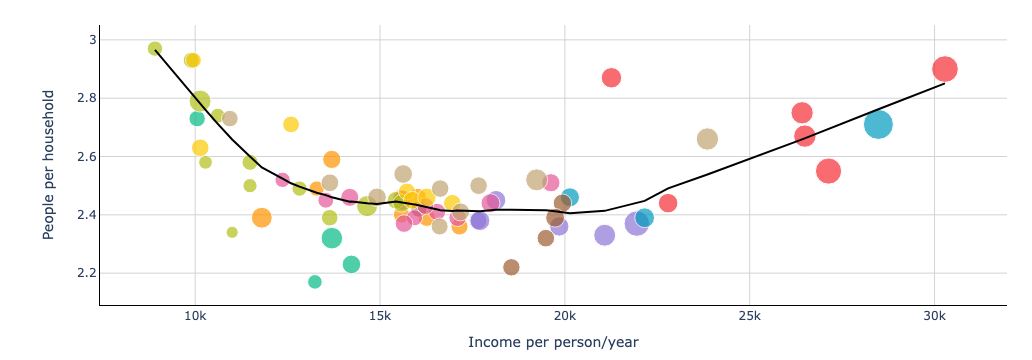

In [87]:
# Define maximum size and normalize sizes
max_size = 30 #maximum dot size we want in our plot
marker_sizes = (df_hoods['mean_size'] / df_hoods['mean_size'].max()) * max_size #normalize sizes

#create a scatter plot
scatter = go.Scatter(
    x=df_hoods["income_per_person"],
    y=df_hoods["mean_people_household"],
    text=df_hoods['neighborhood_name'],
    mode='markers',
    marker=dict(color=df_hoods['color'], size=marker_sizes), #making color and dot size depend on district and normalized apartment sizes, respectively
    customdata= np.stack((df_hoods['district_name'], df_hoods['neighborhood_name'], df_hoods['income_per_person'], df_hoods['mean_people_household'], df_hoods['mean_size']), axis=-1),
    hovertemplate =
    '<br><b>District: %{customdata[0]}</b></br>' + 
    '<b>Neighborhood: %{customdata[1]}</b>' + 
    '<br><b>Income per person/year (€): %{customdata[2]}</b></br>' + 
    '<b>People per household: %{customdata[2]}</b>' + 
    '<br><b>Apartment size (sqm): %{customdata[3]}</b><extra></extra></br>' #add extra to remove trace:0 right next to hover box
)

#calculate LOWESS line
df_hoods = df_hoods.sort_values(by='income_per_person') #sort the DataFrame by the 'income_per_person' column, necessary to calculate the LOWESS line
lowess_result = lowess(df_hoods["mean_people_household"], df_hoods["income_per_person"], frac=0.3)
lowess_line = go.Scatter(
    x=df_hoods["income_per_person"],
    y=lowess_result[:, 1],
    mode='lines',
    line=dict(color='black', width=2),
    hoverinfo='none',
)

#create figure
fig4 = go.Figure(data=[scatter, lowess_line], layout=mylayout)

# update layout with axes titles and margins
fig4.update_layout(
    xaxis=dict(title='Income per person/year'),
    yaxis=dict(title='People per household'),
    margin=dict(l=100, r=25, b=50, t=25),#customizing margins
    showlegend=False
)

#show the figure
fig4.show()

There we go. While it's not immediately clear that people in low-income neighborhoods live in smaller apartments than people in mid-income neighborhoods, it's very obvious that people enjoy bigger apartments in the wealthiest neighborhoods.

## 6. Conclusion

We initially asked what the relationship was between the income of a certain person and the number of people this person shared a roof with. By using four different datasets we've dug into the matter and seen that, at least in the context of Barcelona, the relationship appears to be U-shaped. At both ends of the economic spectrum people live with more people, whereas the middle class dwells in less-populated apartments. However, we've also found evidence that leads us to think that wealthier people live in more spacious apartments, which means that they are probably less crowded. 